# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../../')

In [3]:
from src.serve import *

In [4]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [5]:
bs=16
bptt=256

In [27]:
data_dir = 'data/midi/v10/'
source_dir = 'midi_encode'

file_path = Path('../../')
path = file_path/data_dir/source_dir
out_path = file_path/'data/generated/'

In [28]:
config = v10_config(vocab_path=path/'tmp/all'); config

{'ctx_len': 150,
 'n_layers': 12,
 'n_heads': 12,
 'd_model': 256,
 'd_head': 64,
 'd_inner': 2100,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'emb_map': [(0, 130, 128), (1, 132, 128)],
 'idx_map': {0: (0, 130, 128), 1: (1, 132, 128)},
 'loss_weights': [1, 1],
 'pad_idx': 0,
 'bos_idx': 2,
 'enc_offset': 3,
 'transpose_range': (0, 12),
 'mask_type': <MaskType.RandomWindow: 3>,
 'bs': 16,
 'bptt': 256}

In [8]:
data = load_data(path=path, cache_name='tmp/hook', **config)

In [9]:
path

PosixPath('../../data/midi/v10/midi_encode')

In [15]:
saved_models = get_files(path/'models/hook_c', recurse=True); saved_models

[PosixPath('../../data/midi/v10/midi_encode/models/hook_c/2_ep30.pth'),
 PosixPath('../../data/midi/v10/midi_encode/models/hook_c/2_ep30_best.pth'),
 PosixPath('../../data/midi/v10/midi_encode/models/hook_c/1_ep50.pth'),
 PosixPath('../../data/midi/v10/midi_encode/models/hook_c/1_ep50_best.pth')]

In [16]:
load_path = saved_models[1]

In [17]:
learn = load_learner(data, config, load_path)

In [18]:
# htlist = get_htlist(path, source_dir)

### From batch

In [20]:
xb,yb = learn.data.one_batch(cpu=False)

### From song

In [32]:

csv_path = path/f'{source_dir}.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

In [142]:
keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('flows')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'musescore']; results.head()

,ht_bpm,md5,numpy,ht_time_signature,midi_title,source,artist,ht_offset,section,song_url,mxl,ht_key,parts,title,genres,midi,ht_mode
56458,NaN,6b9ca5372ccc88e8091d40f295d57f27,midi_encode/musescore/data/4272456.npy,NaN,NaN,musescore,ArnavAmit,NaN,NaN,NaN,midi_sources/musescore/data/4272456.mxl,NaN,NaN,River flows in you,"classical,pop,inferred",NaN,NaN
59842,NaN,c6e9d95919225f8d643c4e9332fcd1c4,midi_encode/musescore/data/4743256.npy,NaN,NaN,musescore,Christian Pich von Lipinski,NaN,NaN,NaN,midi_sources/musescore/data/4743256.mxl,NaN,NaN,River flows in you (easy arrangement),"classical,pop,inferred",NaN,NaN
60321,NaN,d923b7a1b02c90f22b07817a268d8860,midi_encode/musescore/data/4965414.npy,NaN,NaN,musescore,Rea H,NaN,NaN,NaN,midi_sources/musescore/data/4965414.mxl,NaN,NaN,River flows in you - piano,"classical,pop,inferred",NaN,NaN


In [143]:
file = file_path/data_dir/results.numpy.values[0]; file

PosixPath('../../data/midi/v10/midi_encode/musescore/data/4272456.npy')

In [144]:
# file = np.random.choice(files)

In [145]:
#good_one = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
# file = Path('../../data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy')
# third_eye = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')

In [159]:
seed_len = 100
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(seed_np)[None]
if torch.cuda.is_available(): xb = xb.cuda()

### Predict

In [147]:
# res1 = torch.randint(0, 1000, (10,10)).float(); res1

# res2 = res1.pow(1 / 10)
# res2 = res2 / res2.sum()
# (res2*1000).round()/1000

# resd5 = res1.pow(1 / .5)
# resd5_prob = resd5 / resd5.sum()
# (resd5_prob*1000).round()/1000

In [148]:
# out, seed = learn.predict(xb, n_words=340, temperature=1, min_p=0.01)

In [149]:
# Higher temperature = More randomness (1.5)
# Lower temperature = Less random (.5)

In [150]:
def predict(self, xb, n_words:int=1, min_length=100,
            temperatures=(1.4,0.5), min_ps=(1/128,0.0),
            adaptive_ratio=(0.3,0.6,.1)):
    "Return the `n_words` that come after `text`."
    ds = self.data.single_dl.dataset
    self.model.reset()
    self.model[0].mask = False
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy()
    yb = torch.ones_like(xb)
    
    running_ps = [1, 1]
    
    timesteps = []
    for _ in progress_bar(range(n_words), leave=True):
        bar = []
        outputs = self.pred_batch(batch=(xb,yb))
        for idx,item in enumerate(outputs): #progress_bar(range(n_words), leave=False):
            res = item[0][-1]
            min_p,temperature = min_ps[idx], temperatures[idx]
#                 if idx == 0: print('Items over p:', (res >= min_p).float().sum(), res.shape)
            if (res >= min_p).float().sum() == 0:
                warn(f"There is no item with probability >= {min_p}, try a lower value.")
            else: res[res < min_p] = 0.

            if len(timesteps) < min_length: res[self.bos_idx] = 0.

            res_temp = res.pow(1 / (temperature * running_ps[idx]))
            mult_idx = torch.multinomial(res_temp, 1)
            
            if adaptive_ratio is not None:
                mult_p = res[mult_idx].item() * adaptive_ratio[0]
                running_p = running_ps[idx] * adaptive_ratio[1]
                other_p = running_ps[(idx+1)%len(running_ps)] * adaptive_ratio[2]
                running_ps[idx] = mult_p + running_p + other_p
                if res[mult_idx].item() < .5:
                    print('Mult p:', res[mult_idx].item(), running_ps[idx])
#             val,idx = torch.topk(res, 1)
            bar.append(mult_idx.squeeze().to(xb.device))
        bar = torch.stack(bar, dim=-1)
        if self.bos_idx is not None and (bar==self.bos_idx).any(): 
            print('Predicted BOS token. Returning prediction...')
            break
        timesteps.append(bar.cpu().numpy())
        xb = bar.clone().detach()[None,None] # don't use timesteps. use it's own memory instead

    self.model[0].mask = True
    return timesteps, seed.squeeze()


In [194]:
out, seed = predict(learn, xb, n_words=340, temperatures=(1.2,.5))
# out, seed = predict(learn, xb, n_words=340, temperatures=(1.2,.3), adaptive_ratio=None)

Mult p: 0.3573128283023834 0.807193848490715
Mult p: 0.07995682209730148 0.6269938020995683
Mult p: 0.4034454822540283 0.742293387257939
Mult p: 0.16921965777873993 0.6804281475626761
Mult p: 0.052947748452425 0.6496219862144055
Mult p: 0.025194503366947174 0.693031190895651
Mult p: 0.30992498993873596 0.703135843262715
Mult p: 0.14424020051956177 0.5990084609648825
Mult p: 0.012068422511219978 0.6291777199146888
Mult p: 0.3978147506713867 0.7183304455842929
Mult p: 0.14539550244808197 0.5705145972246329
Mult p: 0.37335410714149475 0.5533529661038276
Mult p: 0.377139687538147 0.5467704885751595
Mult p: 0.02771935798227787 0.6977088776237339
Predicted BOS token. Returning prediction...


In [195]:
# out, seed = learn.predict(xb, n_words=340, temperatures=(1.2,.5), min_ps=(1/128,0.0))

### Actual prediction

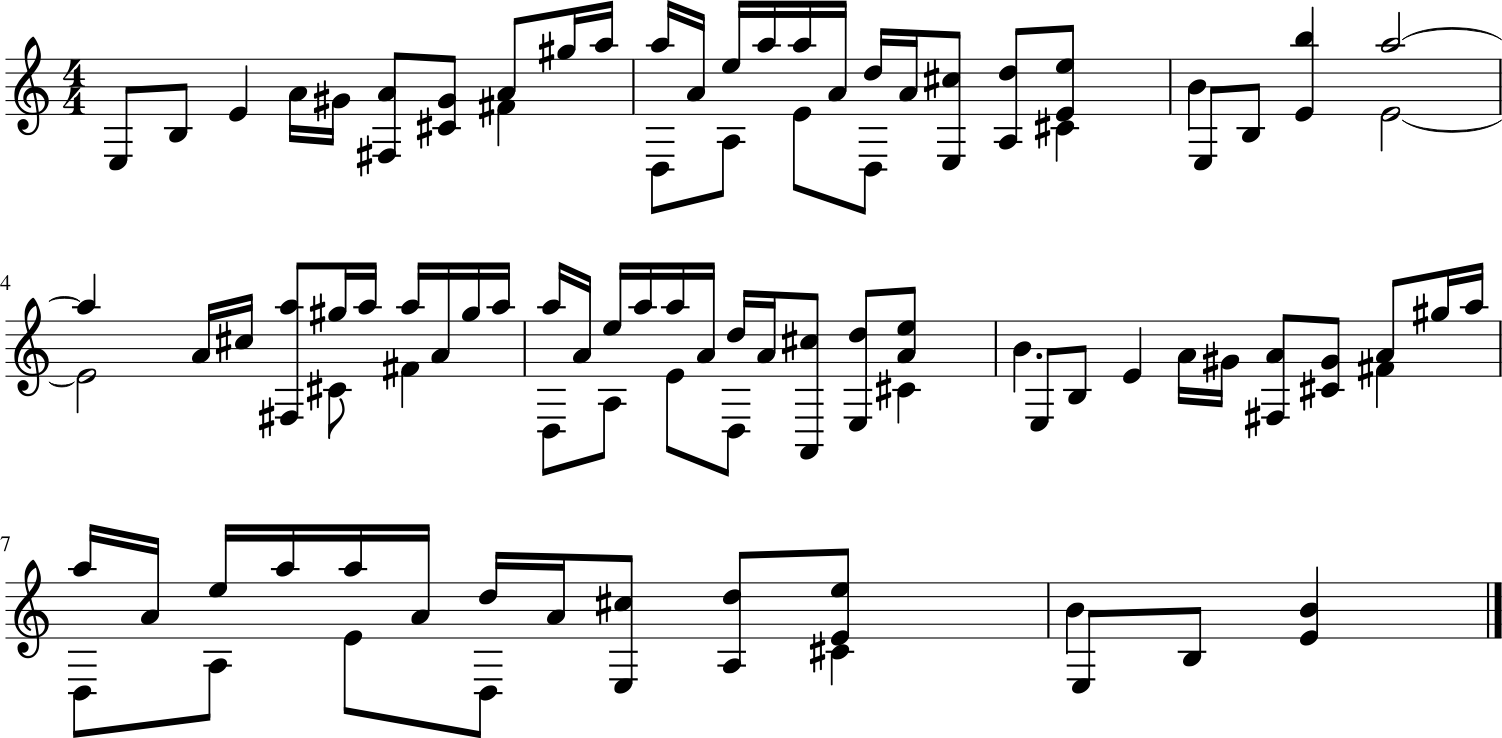

In [196]:
stream = npenc2stream(out)
stream.show()

In [197]:
stream.show('midi')

## Seed

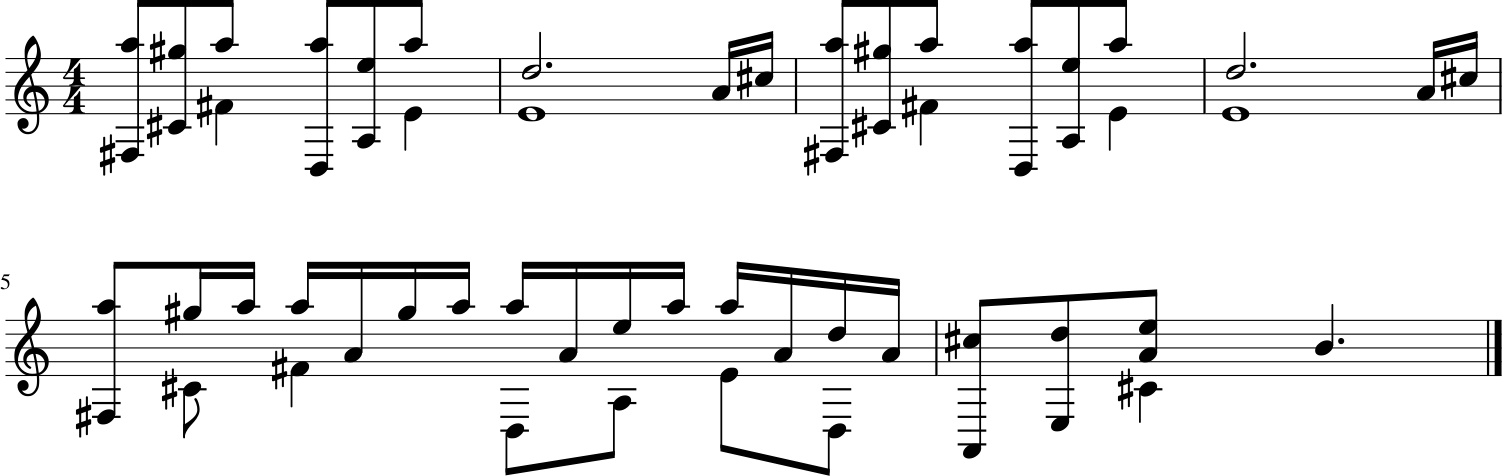

In [198]:
seed_stream = npenc2stream(seed)
seed_stream.show()

In [199]:
seed_stream.show('midi')

## Alltogether now

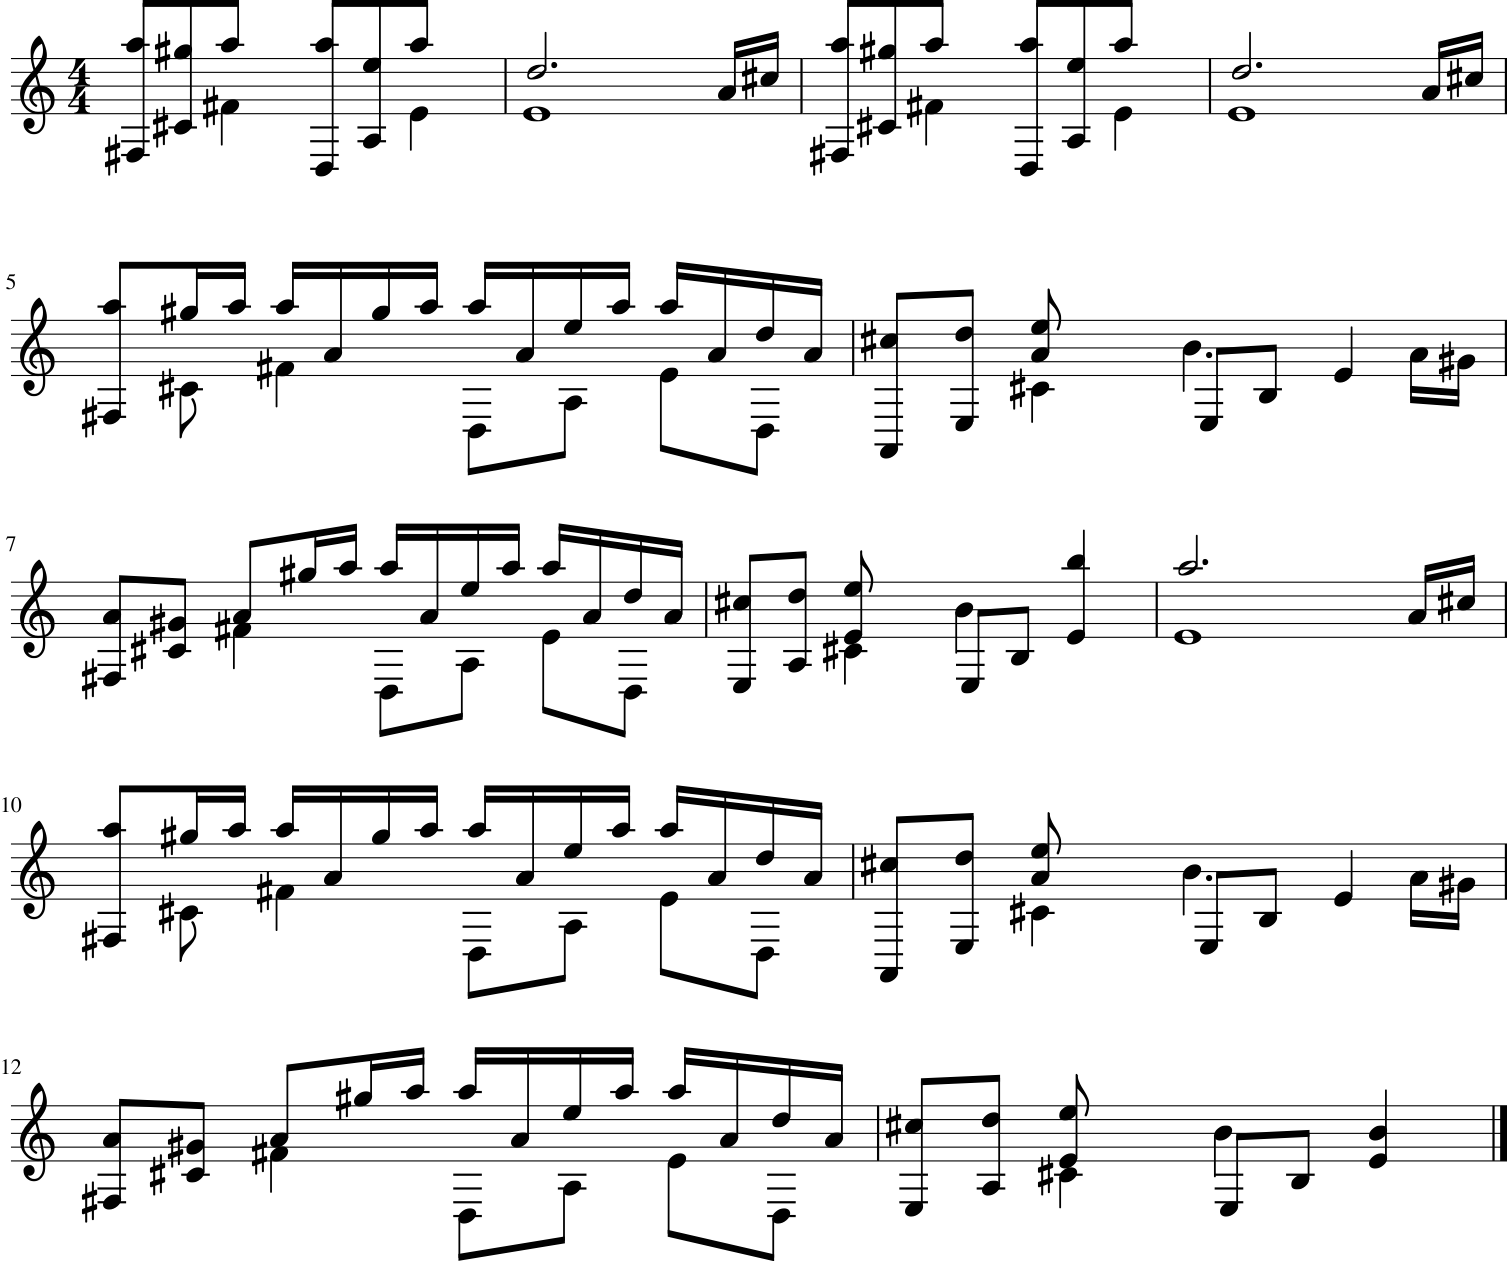

In [200]:
full_output = np.concatenate((seed,out), axis=0)
full_stream = npenc2stream(full_output)
full_stream.show()

In [201]:
full_stream.show('midi')

### Original

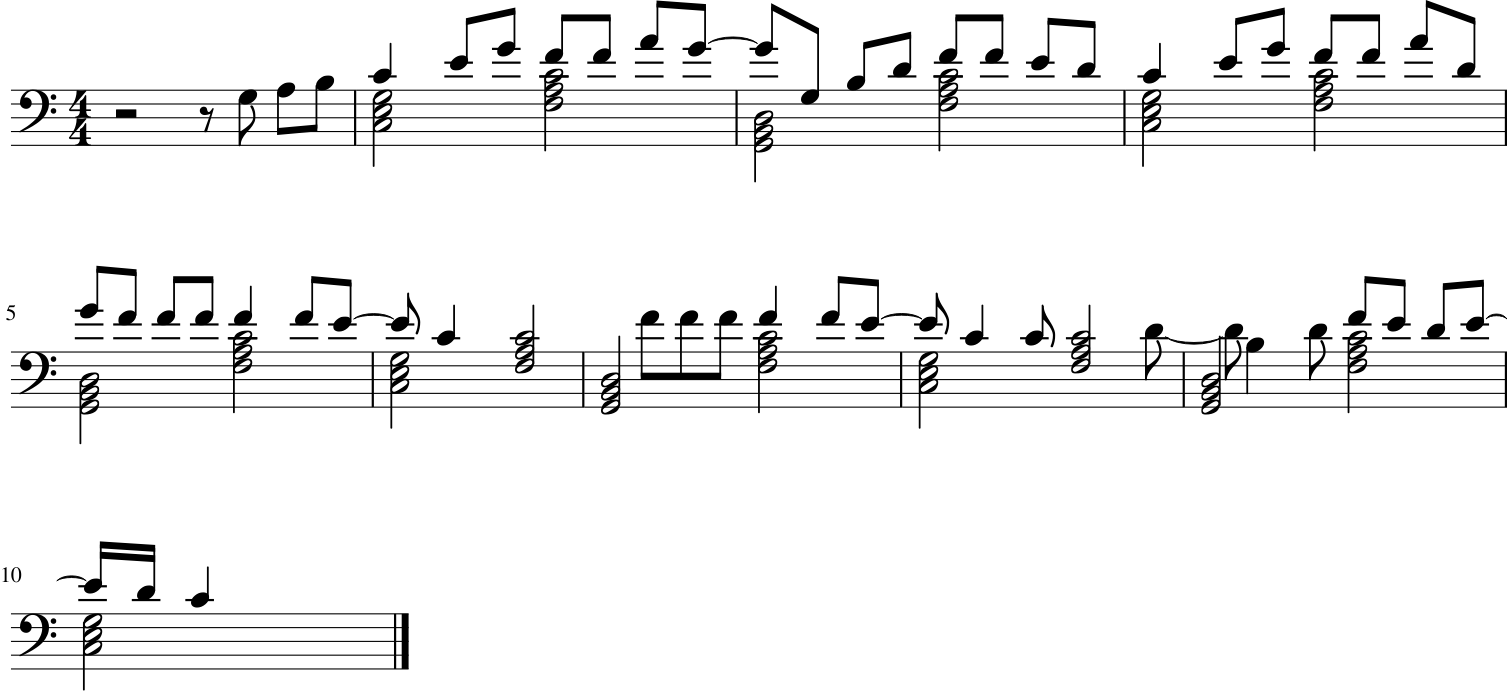

In [61]:
original_stream = npenc2stream(song_np)
original_stream.show()

In [62]:
original_stream.show('midi')